In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## 패키지

In [2]:
!pip install pymysql
!sudo apt-get install -y fonts-nanum # 나눔 폰트 설치 (설치 후 런타임 재시작하고 코드 실행)
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory

In [3]:
import numpy as np
import pandas as pd
import pymysql
from sqlalchemy import create_engine
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
import random
font_name = fm.FontProperties().get_name()
plt.rc('font', family=font_name) # 한글 출력

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 로드

In [5]:
# DB 연결
endpoint = 'dao.c51deksujiip.ap-northeast-2.rds.amazonaws.com'
schema_name = 'dao'
db_connection_str = 'mysql+pymysql://admin:ekfkawnl@{}/{}'.format(endpoint, schema_name )
try :
    db_connection = create_engine(db_connection_str)
    conn = db_connection.connect()
except :
    print('fail to connect db')

In [6]:
def sql_to_df(table_name):
    sql = "SELECT * FROM {}".format(table_name)
    df = pd.read_sql(sql, db_connection)
    return df

In [7]:
df = sql_to_df('MainData_차선수_이산형')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   번호                497 non-null    int64  
 1   위도                497 non-null    float64
 2   경도                497 non-null    float64
 3   생태통로_유형           497 non-null    int64  
 4   등산객_이용빈도          497 non-null    int64  
 5   생태통로_효율성          497 non-null    int64  
 6   이용확인종_수           497 non-null    int64  
 7   폭(m)              309 non-null    float64
 8   연장(m)             309 non-null    float64
 9   높이(m)             44 non-null     float64
 10  개방도               44 non-null     float64
 11  경사도               497 non-null    object 
 12  주변 로드킬 빈도         497 non-null    int64  
 13  산책로까지의 최단 거리(km)  497 non-null    float64
 14  농가까지의 거리(km)      497 non-null    float64
 15  도로 최고제한속도(km/h)   497 non-null    int64  
 16  지형기호(2.3km)       497 non-null    object 
 1

### 사용하지 않는 열 삭제

In [8]:
df.drop(['최우점식물군락', '주변 로드킬 빈도'], axis=1, inplace=True)

## 식생, 지형 내용 변경

In [9]:
df['식물군락명'] = [0 if ((not '나무' in x) | (not '군락' in x)) else x for x in df['식물군락명']]
df['식물군락명'] = [1 if x!=0 else x for x in df['식물군락명']]
df['식물군락명'].unique()

array([1, 0])

In [10]:
df['지형기호(2.3km)'] = [x.split('-')[0] for x in df['지형기호(2.3km)']]
df['지형기호(2.3km)'].unique()

array(['X', '하천', '산지', '기타', '해안', '화산'], dtype=object)

In [11]:
df.rename(columns={'식물군락명':'식생'}, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   번호                497 non-null    int64  
 1   위도                497 non-null    float64
 2   경도                497 non-null    float64
 3   생태통로_유형           497 non-null    int64  
 4   등산객_이용빈도          497 non-null    int64  
 5   생태통로_효율성          497 non-null    int64  
 6   이용확인종_수           497 non-null    int64  
 7   폭(m)              309 non-null    float64
 8   연장(m)             309 non-null    float64
 9   높이(m)             44 non-null     float64
 10  개방도               44 non-null     float64
 11  경사도               497 non-null    object 
 12  산책로까지의 최단 거리(km)  497 non-null    float64
 13  농가까지의 거리(km)      497 non-null    float64
 14  도로 최고제한속도(km/h)   497 non-null    int64  
 15  지형기호(2.3km)       497 non-null    object 
 16  하천거리(km)          497 non-null    float64
 1

# Split 육교형/터널형

In [13]:
df_overpass = df[df['생태통로_유형'] == 0] # 육교형
df_tunnel = df[df['생태통로_유형'] != 0] # 터널형
df_overpass.drop(['개방도', '높이(m)'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
# index 초기화
df_overpass.reset_index(drop = True,inplace= True)
df_tunnel.reset_index(drop = True,inplace= True)

In [15]:
# 육교형 생태통로 MainData DF 정보
df_overpass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   번호                300 non-null    int64  
 1   위도                300 non-null    float64
 2   경도                300 non-null    float64
 3   생태통로_유형           300 non-null    int64  
 4   등산객_이용빈도          300 non-null    int64  
 5   생태통로_효율성          300 non-null    int64  
 6   이용확인종_수           300 non-null    int64  
 7   폭(m)              264 non-null    float64
 8   연장(m)             264 non-null    float64
 9   경사도               300 non-null    object 
 10  산책로까지의 최단 거리(km)  300 non-null    float64
 11  농가까지의 거리(km)      300 non-null    float64
 12  도로 최고제한속도(km/h)   300 non-null    int64  
 13  지형기호(2.3km)       300 non-null    object 
 14  하천거리(km)          300 non-null    float64
 15  식생                300 non-null    int64  
 16  등산로까지 최단거리(km)    300 non-null    float64
 1

In [16]:
# 터널형 생태통로 MainData DF 정보
df_tunnel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   번호                197 non-null    int64  
 1   위도                197 non-null    float64
 2   경도                197 non-null    float64
 3   생태통로_유형           197 non-null    int64  
 4   등산객_이용빈도          197 non-null    int64  
 5   생태통로_효율성          197 non-null    int64  
 6   이용확인종_수           197 non-null    int64  
 7   폭(m)              45 non-null     float64
 8   연장(m)             45 non-null     float64
 9   높이(m)             43 non-null     float64
 10  개방도               43 non-null     float64
 11  경사도               197 non-null    object 
 12  산책로까지의 최단 거리(km)  197 non-null    float64
 13  농가까지의 거리(km)      197 non-null    float64
 14  도로 최고제한속도(km/h)   197 non-null    int64  
 15  지형기호(2.3km)       197 non-null    object 
 16  하천거리(km)          197 non-null    float64
 1

# 이상치

## 이상치 확인

In [17]:
# 이상치 처리해야 할 컬럼 목록
overpass_check = ['차선_수', '이용확인종_수', '폭(m)', '연장(m)', '산책로까지의 최단 거리(km)',
                  '농가까지의 거리(km)', '도로 최고제한속도(km/h)', '주변 동물종 개수', '주변동물 출현빈도', '하천거리(km)', 
                  '등산로까지 최단거리(km)', '유도울타리_연장_m', '유도울타리_높이_m', '교통량', '건물까지거리(km)']

tunnel_check = ['차선_수', '이용확인종_수', '폭(m)', '연장(m)', '높이(m)', '개방도',
                '산책로까지의 최단 거리(km)', '농가까지의 거리(km)', '도로 최고제한속도(km/h)', '주변 동물종 개수', '주변동물 출현빈도', 
                '하천거리(km)', '등산로까지 최단거리(km)', '유도울타리_연장_m', '유도울타리_높이_m', '교통량', '건물까지거리(km)']

print(len(overpass_check))
print(len(tunnel_check))

15
17


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_

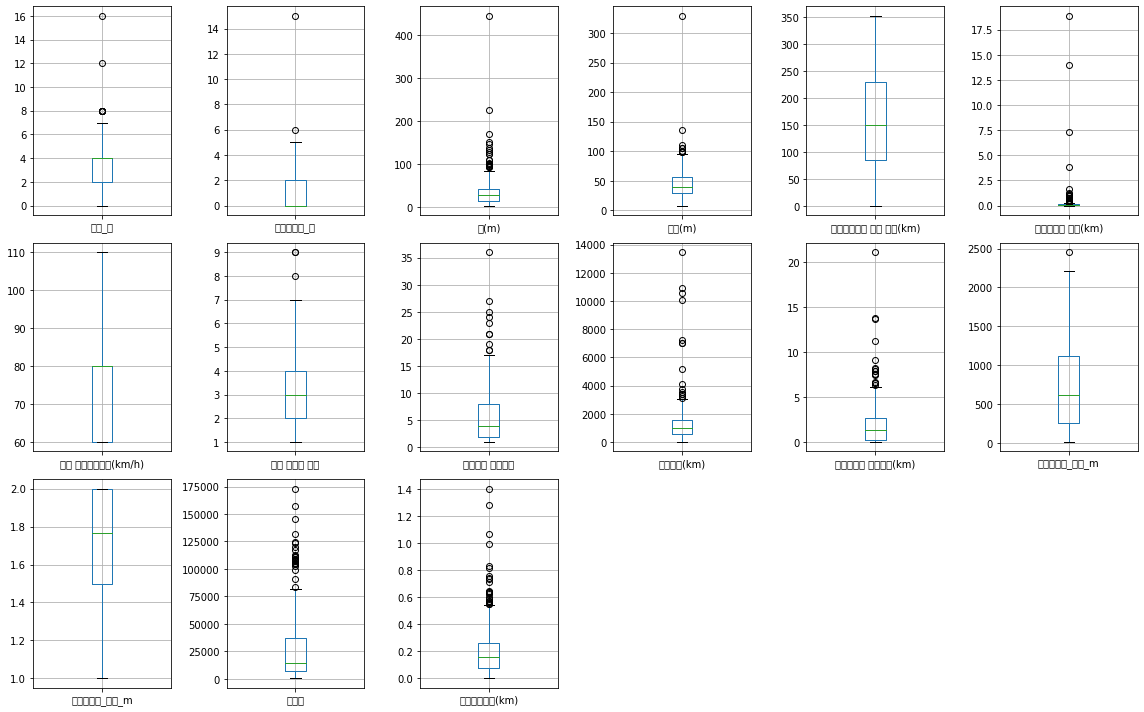

In [18]:
# 육교형 생태통로 Boxplot
plt.figure(figsize=(16, 10))

for i, col in enumerate(overpass_check):
  plt.subplot(3, 6, i+1)
  df_overpass.boxplot(col)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_

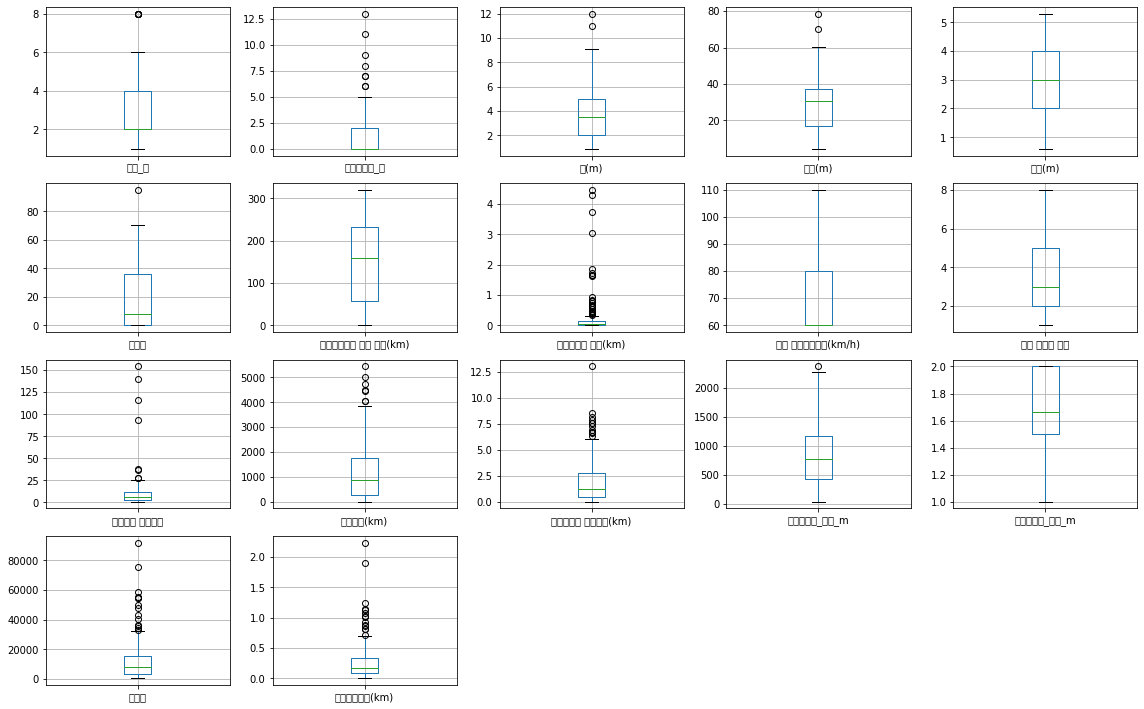

In [19]:
# 터널형 생태통로 Boxplot
plt.figure(figsize=(16, 10))

for i, col in enumerate(tunnel_check):
  plt.subplot(4, 5, i+1)
  df_tunnel.boxplot(col)

plt.tight_layout()
plt.show()

## 이상치 처리

tukey fence 방식으로 처리

In [20]:
# 높은 이상치는 Boxplot의 상한값으로, 낮은 이상치는 Boxplot의 하한값으로 대체하는 함수
def change_outlier(df, col_list):
  for col_name in col_list:
      Q1 = df[col_name].quantile(q=0.25)
      Q3 = df[col_name].quantile(q=0.75)
      IQR = Q3-Q1

      print('[' + col_name + ']', end=' ')
      high_idx = df[df[col_name] > (Q3+1.5*IQR)].index
      df.loc[high_idx, col_name] = round(Q3+1.5*IQR, 1)
      print(str(len(high_idx)) +'개가 상한값으로 변경됨', end=' / ')

      low_idx = df[df[col_name] < (Q1-1.5*IQR)].index
      df.loc[low_idx, col_name] = round(Q1-1.5*IQR, 1)
      print(str(len(low_idx)) +'개가 하한값으로 변경됨')

  return df

In [21]:
# 육교형 이상치 처리
df_overpass = change_outlier(df_overpass, overpass_check)

[차선_수] 8개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[이용확인종_수] 2개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[폭(m)] 21개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[연장(m)] 9개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[산책로까지의 최단 거리(km)] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[농가까지의 거리(km)] 26개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[도로 최고제한속도(km/h)] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[주변 동물종 개수] 3개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[주변동물 출현빈도] 10개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[하천거리(km)] 15개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[등산로까지 최단거리(km)] 16개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[유도울타리_연장_m] 1개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[유도울타리_높이_m] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[교통량] 29개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[건물까지거리(km)] 23개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [22]:
# 터널형 이상치 처리
df_tunnel = change_outlier(df_tunnel, tunnel_check) 

[차선_수] 5개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[이용확인종_수] 8개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[폭(m)] 2개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[연장(m)] 2개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[높이(m)] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[개방도] 1개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[산책로까지의 최단 거리(km)] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[농가까지의 거리(km)] 27개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[도로 최고제한속도(km/h)] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[주변 동물종 개수] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[주변동물 출현빈도] 8개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[하천거리(km)] 7개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[등산로까지 최단거리(km)] 12개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[유도울타리_연장_m] 1개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[유도울타리_높이_m] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[교통량] 14개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[건물까지거리(km)] 14개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨


In [23]:
# 이상치 처리된 MainData DF → DB로 업로드
# df_overpass.to_sql(name='MainData_outlier_overpass', con=db_connection, if_exists='replace', index=False)
# df_tunnel.to_sql(name='MainData_outlier_tunnel', con=db_connection, if_exists='replace', index=False)

# 범주형 변수 원핫인코딩

In [24]:
cat_col = ['등산객_이용빈도', '경사도', '환경영향평가점수', '지형기호(2.3km)']
df_overpass = pd.get_dummies(data=df_overpass, columns=cat_col)
df_tunnel = pd.get_dummies(data=df_tunnel, columns=cat_col)

# 결측치 처리

In [25]:
# 유도울타리 높이, 연장, 주변동물 출현빈도, 주변 동물종 개수 => 존재하지 않는 것이므로 0으로 처리
df_overpass[['유도울타리_높이_m', '유도울타리_연장_m', '주변동물 출현빈도', '주변 동물종 개수']] = df_overpass[['유도울타리_높이_m', '유도울타리_연장_m', '주변동물 출현빈도', '주변 동물종 개수']].fillna(0)
df_tunnel[['유도울타리_높이_m', '유도울타리_연장_m', '주변동물 출현빈도', '주변 동물종 개수']] = df_tunnel[['유도울타리_높이_m', '유도울타리_연장_m', '주변동물 출현빈도', '주변 동물종 개수']].fillna(0)

### Case 1. 평균으로 대체

In [26]:
# 규격 데이터의 결측치를 평균으로 대치하는 함수(평균)
def MeanImputation(df, col_list):
  df_copy = df.copy()
  for col_name in col_list:
    df_copy[col_name].fillna(np.round(df_copy[col_name].mean(), 1), inplace=True)
  return df_copy

### Case 2. KNN으로 대체

In [27]:
# KNN 알고리즘으로 결측값 대체 함수
def KNNImputation(df, n_neighbors):
  df_copy = df.copy()
  col = df_copy.columns
  imputer = KNNImputer(n_neighbors=n_neighbors)
  df_imputed = imputer.fit_transform(df_copy)
  df_copy = pd.DataFrame(df_imputed)
  return df_copy, col

## 처리 수행

In [28]:
# [Case 1] 평균으로 대체
df_overpass_mean = MeanImputation(df_overpass, ['폭(m)', '연장(m)', '교통량']) # 육교형
df_tunnel_mean = MeanImputation(df_tunnel, ['폭(m)', '연장(m)', '높이(m)', '개방도', '교통량']) # 터널형

In [29]:
# [Case 2] KNN으로 대체
drop_col = ['번호', '위도', '경도', '유도울타리_위도_2.3km', '유도울타리_경도_2.3km', '일평균이용빈도', '생태통로_유형']
for i in range(1, 6, 2):
  # 육교형
  df_over, col_over = KNNImputation(df_overpass.drop(drop_col, axis=1, inplace=False), i)
  df_over.columns = col_over
  globals()['df_overpass_knn{}'.format(i)] = pd.concat([df_overpass['일평균이용빈도'],df_over], axis = 1)

  # 터널형
  df_tun, col_tun = KNNImputation(df_tunnel.drop(drop_col, axis=1, inplace=False), i)
  df_tun.columns = col_tun
  globals()['df_tunnel_knn{}'.format(i)] = pd.concat([df_tunnel['일평균이용빈도'],df_tun], axis = 1)

# 생태통로 효율성 데이터 처리

## Option. '판단불가' 값을 삭제

In [30]:
# 생태통로 효율성 데이터가 '판단불가' 값이면 삭제하는 함수
def drop_value(df) :
    df_copy = df.copy() # 파라미터로 넣은 데이터프레임 원본이 바뀌지 않도록 복사
    idx = list(df_copy[df_copy['생태통로_효율성'] == 3].index) # 효율성 3 : 판단불가
    df_copy.drop(idx, inplace=True)
    return df_copy

## 이항 변수 처리

In [31]:
# 생태통로 효율성 컬럼의 각 고유값의 개수, 비율 확인 함수
def check_vc(df):
  vc = df['생태통로_효율성'].value_counts() # 각 값의 개수
  print(vc)
  print(df['생태통로_효율성'].value_counts(normalize=True)) # 각 값의 비율
  return vc


# 이항 변수 처리 함수 : 종속변수(생태통로 효율성)를 이항 변수로 변경
def dep_to_binary(df_ori, is_droped=False):
  df = df_ori.copy()

  # 0은 0(낮음)으로 유지 / 1,2를 1(보통 이상)으로 변경
  df.loc[(df['생태통로_효율성'] == 1) | (df['생태통로_효율성'] == 2), '생태통로_효율성'] = 1
  if is_droped :
      return df

  print('-----' * 20)
  print('[분배 전]')
  vc = check_vc(df)
  print('-----' * 20)

  # 3(판단불가) 값을 0, 1에 각 분포가 비슷해지도록 랜덤 분배
  n0 = int((df.shape[0] / 2) - vc[0]) # 0에 채워야 하는 개수
  n1 = int((df.shape[0] / 2) - vc[1]) # 1에 채워야 하는 개수

  random.seed(100)
  idx_list = list(df[df['생태통로_효율성'] == 3].index)
  n0_idx_list = random.sample(idx_list, n0)
  n1_idx_list = list(set(idx_list) - set(n0_idx_list))

  df.loc[n0_idx_list, '생태통로_효율성'] = 0
  df.loc[n1_idx_list, '생태통로_효율성'] = 1

  print('[분배 후]')
  check_vc(df)
  print('-----' * 20)
  print('\n' * 2)
  return df

## 처리 수행

In [32]:
# 결측치 : 평균 / 효율성 : '판단불가' 값 삭제 후 binary
overpass_mean_drop = drop_value(df_overpass_mean)
overpass_mean_drop = dep_to_binary(overpass_mean_drop, is_droped=True)

tunnel_mean_drop = drop_value(df_tunnel_mean)
tunnel_mean_drop = dep_to_binary(tunnel_mean_drop, is_droped=True)

In [33]:
# 결측치 : 평균 / 효율성 : '판단불가' 값 삭제하지 않고 binary
overpass_mean_binary = dep_to_binary(df_overpass_mean)
tunnel_mean_binary = dep_to_binary(df_tunnel_mean)

----------------------------------------------------------------------------------------------------
[분배 전]
3    117
1    108
0     75
Name: 생태통로_효율성, dtype: int64
3    0.39
1    0.36
0    0.25
Name: 생태통로_효율성, dtype: float64
----------------------------------------------------------------------------------------------------
[분배 후]
0    150
1    150
Name: 생태통로_효율성, dtype: int64
0    0.5
1    0.5
Name: 생태통로_효율성, dtype: float64
----------------------------------------------------------------------------------------------------



----------------------------------------------------------------------------------------------------
[분배 전]
3    75
1    67
0    55
Name: 생태통로_효율성, dtype: int64
3    0.380711
1    0.340102
0    0.279188
Name: 생태통로_효율성, dtype: float64
----------------------------------------------------------------------------------------------------
[분배 후]
1    99
0    98
Name: 생태통로_효율성, dtype: int64
1    0.502538
0    0.497462
Name: 생태통로_효율성, dtype: float64
---------------------

In [34]:
# 결측치 : KNN / 효율성 : '판단불가' 값 삭제 후 binary
for i in range(1, 6, 2):
  globals()['overpass_knn{}_drop'.format(i)] = drop_value(globals()['df_overpass_knn{}'.format(i)])
  globals()['overpass_knn{}_drop'.format(i)] = dep_to_binary(globals()['overpass_knn{}_drop'.format(i)],  is_droped=True)

  globals()['tunnel_knn{}_drop'.format(i)] = drop_value(globals()['df_tunnel_knn{}'.format(i)])
  globals()['tunnel_knn{}_drop'.format(i)] = dep_to_binary(globals()['tunnel_knn{}_drop'.format(i)],  is_droped=True)

In [35]:
# 결측치 : KNN / 효율성 : '판단불가' 값 삭제하지 않고 binary
for i in range(1, 6, 2):
  globals()['overpass_knn{}_binary'.format(i)] = dep_to_binary(globals()['df_overpass_knn{}'.format(i)])
  globals()['tunnel_knn{}_binary'.format(i)] = dep_to_binary(globals()['df_tunnel_knn{}'.format(i)])

----------------------------------------------------------------------------------------------------
[분배 전]
3.0    117
1.0    108
0.0     75
Name: 생태통로_효율성, dtype: int64
3.0    0.39
1.0    0.36
0.0    0.25
Name: 생태통로_효율성, dtype: float64
----------------------------------------------------------------------------------------------------
[분배 후]
0.0    150
1.0    150
Name: 생태통로_효율성, dtype: int64
0.0    0.5
1.0    0.5
Name: 생태통로_효율성, dtype: float64
----------------------------------------------------------------------------------------------------



----------------------------------------------------------------------------------------------------
[분배 전]
3.0    75
1.0    67
0.0    55
Name: 생태통로_효율성, dtype: int64
3.0    0.380711
1.0    0.340102
0.0    0.279188
Name: 생태통로_효율성, dtype: float64
----------------------------------------------------------------------------------------------------
[분배 후]
1.0    99
0.0    98
Name: 생태통로_효율성, dtype: int64
1.0    0.502538
0.0    0.497462
Name: 생태통로_효

# 최종 데이터

In [36]:
df_list = [overpass_mean_binary, tunnel_mean_binary, overpass_mean_drop, tunnel_mean_drop] \
        + [globals()['overpass_knn{}_binary'.format(i)] for i in range(1, 6, 2)] \
        + [globals()['tunnel_knn{}_binary'.format(i)] for i in range(1, 6, 2)] \
        + [globals()['overpass_knn{}_drop'.format(i)] for i in range(1, 6, 2)] \
        + [globals()['tunnel_knn{}_drop'.format(i)] for i in range(1, 6, 2)]
        
print(len(df_list))

16


In [37]:
print([df.shape for df in df_list])

[(300, 47), (197, 49), (183, 47), (122, 49), (300, 41), (300, 41), (300, 41), (197, 43), (197, 43), (197, 43), (183, 41), (183, 41), (183, 41), (122, 43), (122, 43), (122, 43)]


In [39]:
# DF to CSV
path = '/content/drive/MyDrive/2022 데이터 청년 캠퍼스/프로젝트/전처리/MainData_v6/'

overpass_mean_binary.to_csv(path + 'overpass_mean_binary.csv', index=False, encoding='cp949')
tunnel_mean_binary.to_csv(path + 'tunnel_mean_binary.csv', index=False, encoding='cp949')
overpass_mean_drop.to_csv(path + 'overpass_mean_drop.csv', index=False, encoding='cp949')
tunnel_mean_drop.to_csv(path + 'tunnel_mean_drop.csv', index=False, encoding='cp949')
for i in range(1, 6, 2):
  globals()['overpass_knn{}_binary'.format(i)].to_csv(path + 'overpass_knn{}_binary.csv'.format(i), index=False, encoding='cp949')
  globals()['tunnel_knn{}_binary'.format(i)].to_csv(path + 'tunnel_knn{}_binary.csv'.format(i), index=False, encoding='cp949')
  globals()['overpass_knn{}_drop'.format(i)].to_csv(path + 'overpass_knn{}_drop.csv'.format(i), index=False, encoding='cp949')
  globals()['tunnel_knn{}_drop'.format(i)].to_csv(path + 'tunnel_knn{}_drop.csv'.format(i), index=False, encoding='cp949')